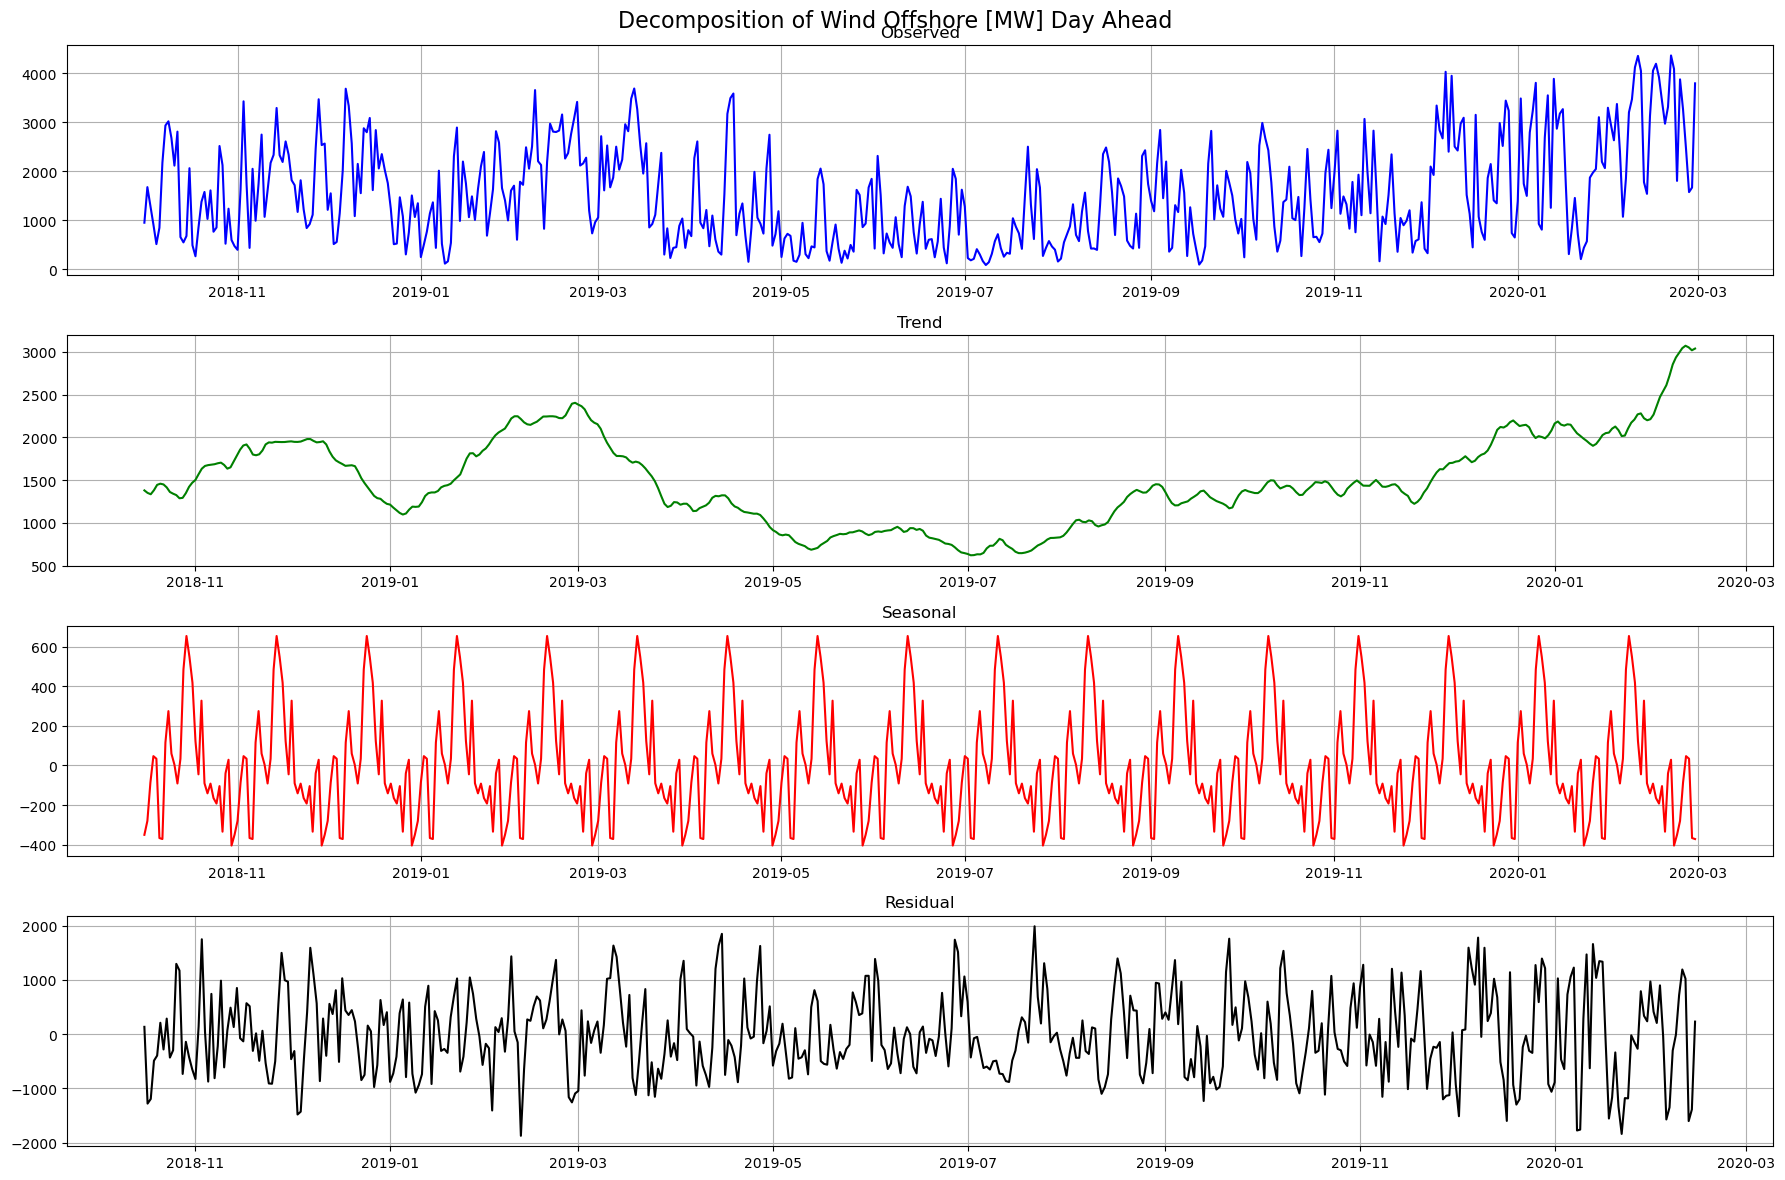

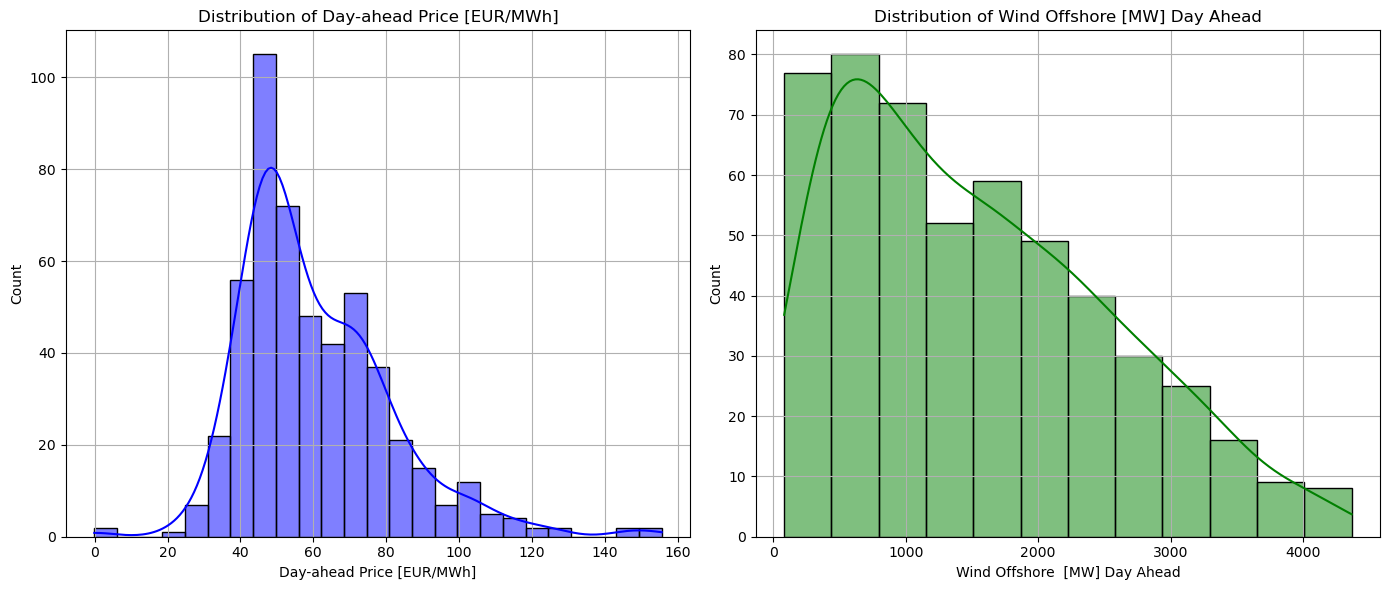

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
df = pd.read_csv('reshaped_dataset_corrected-2018-2020.csv')

# Convert 'Date' to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

# Decomposing the Wind Offshore [MW] Day Ahead time series with a period of 30 days
decomposition_wind = seasonal_decompose(df['Wind Offshore  [MW] Day Ahead'], model='additive', period=30)

# Plotting the decomposition for Wind Offshore [MW] Day Ahead
plt.figure(figsize=(18, 12))
plt.suptitle('Decomposition of Wind Offshore [MW] Day Ahead', fontsize=16)

plt.subplot(4, 1, 1)
plt.plot(decomposition_wind.observed, color='blue')
plt.title('Observed')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(decomposition_wind.trend, color='green')
plt.title('Trend')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(decomposition_wind.seasonal, color='red')
plt.title('Seasonal')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(decomposition_wind.resid, color='black')
plt.title('Residual')
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Plotting the distribution of both variables
plt.figure(figsize=(14, 6))

# Distribution of Day-ahead Price
plt.subplot(1, 2, 1)
sns.histplot(df['Day-ahead Price [EUR/MWh]'], kde=True, color='blue')
plt.title('Distribution of Day-ahead Price [EUR/MWh]')
plt.grid(True)

# Distribution of Wind Offshore Power Prediction
plt.subplot(1, 2, 2)
sns.histplot(df['Wind Offshore  [MW] Day Ahead'], kde=True, color='green')
plt.title('Distribution of Wind Offshore [MW] Day Ahead')
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
head = df.head()
print(head)
print(" ")
tail = df.tail()
print(tail)

            Day-ahead Price [EUR/MWh]  Wind Offshore  [MW] Day Ahead
Date                                                                
2018-10-01                     100.00                     946.916667
2018-10-02                      72.22                    1674.083333
2018-10-03                      80.61                    1291.333333
2018-10-04                      71.60                     910.791667
2018-10-05                      80.55                     509.666667
 
            Day-ahead Price [EUR/MWh]  Wind Offshore  [MW] Day Ahead
Date                                                                
2020-02-25                      39.08                    3261.250000
2020-02-26                      38.68                    2447.291667
2020-02-27                      44.76                    1572.333333
2020-02-28                      43.06                    1665.750000
2020-02-29                      35.00                    3796.083333


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('reshaped_dataset_corrected-2018-2020.csv')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Save dates before introducing lag features
dates = df['Date'].tolist()

# Drop the 'Date' column after saving
df.drop(columns='Date', inplace=True)

# Generate lag features for both the target variable and the wind offshore power prediction
for i in range(1, 8):
    df[f'Price_Lag_{i}'] = df['Day-ahead Price [EUR/MWh]'].shift(i)
    df[f'Wind_Lag_{i}'] = df['Wind Offshore  [MW] Day Ahead'].shift(i)

# Drop NaN rows introduced by the lag features
df.dropna(inplace=True)

# Splitting the dataset
n_train_hours = int(len(df) * 0.8)
train, test = df.iloc[:n_train_hours, :], df.iloc[n_train_hours:, :]

# Extract test dates
test_dates = dates[n_train_hours:n_train_hours + len(test)]  # Adjusted to match test set length

# Sorting the index
train.sort_index(inplace=True)
test.sort_index(inplace=True)

# Separating the target variable
train_X, train_y = train.drop(columns=['Day-ahead Price [EUR/MWh]']), train['Day-ahead Price [EUR/MWh]']
test_X, test_y = test.drop(columns=['Day-ahead Price [EUR/MWh]']), test['Day-ahead Price [EUR/MWh]']

# Scaling the dataset
scaler_X = StandardScaler().fit(train_X)
train_X_scaled = scaler_X.transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

scaler_y = StandardScaler().fit(train_y.values.reshape(-1, 1))
train_y_scaled = scaler_y.transform(train_y.values.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1))

# Reshaping for LSTM
train_X_reshaped = train_X_scaled.reshape((train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_reshaped = test_X_scaled.reshape((test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))

# Adjusted LSTM model architecture
model = Sequential()
model.add(LSTM(60, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

# Adjusting the optimizer's learning rate
optimizer = Adam(learning_rate=0.005)
model.compile(loss='mae', optimizer=optimizer)

# Adjusted batch size
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Training the model
history = model.fit(train_X_reshaped, train_y_scaled, epochs=50, batch_size=batch_size, 
                    validation_data=(test_X_reshaped, test_y_scaled), verbose=2, 
                    shuffle=False, callbacks=[early_stop])

# Prediction
yhat_scaled = model.predict(test_X_reshaped)

# Inverse scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat_scaled)

# Inverse scaling for actuals
inv_y = scaler_y.inverse_transform(test_y_scaled)

# RMSE calculation
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:', rmse)



C:\Users\ridva\AppData\Local\Temp\ipykernel_14244\2566933045.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


Epoch 1/50
13/13 - 3s - loss: 0.7572 - val_loss: 0.8058 - 3s/epoch - 269ms/step
Epoch 2/50
13/13 - 0s - loss: 0.6168 - val_loss: 0.4132 - 51ms/epoch - 4ms/step
Epoch 3/50
13/13 - 0s - loss: 0.5518 - val_loss: 0.3503 - 59ms/epoch - 5ms/step
Epoch 4/50
13/13 - 0s - loss: 0.5267 - val_loss: 0.3352 - 56ms/epoch - 4ms/step
Epoch 5/50
13/13 - 0s - loss: 0.4853 - val_loss: 0.3287 - 50ms/epoch - 4ms/step
Epoch 6/50
13/13 - 0s - loss: 0.4864 - val_loss: 0.3348 - 52ms/epoch - 4ms/step
Epoch 7/50
13/13 - 0s - loss: 0.4657 - val_loss: 0.3425 - 46ms/epoch - 4ms/step
Epoch 8/50
13/13 - 0s - loss: 0.4547 - val_loss: 0.3346 - 49ms/epoch - 4ms/step
Epoch 9/50
13/13 - 0s - loss: 0.4563 - val_loss: 0.3448 - 45ms/epoch - 3ms/step
Epoch 10/50
13/13 - 0s - loss: 0.4648 - val_loss: 0.3420 - 43ms/epoch - 3ms/step
4/4 [==============================] - 1s 2ms/step
Test RMSE: 10.314559607301282


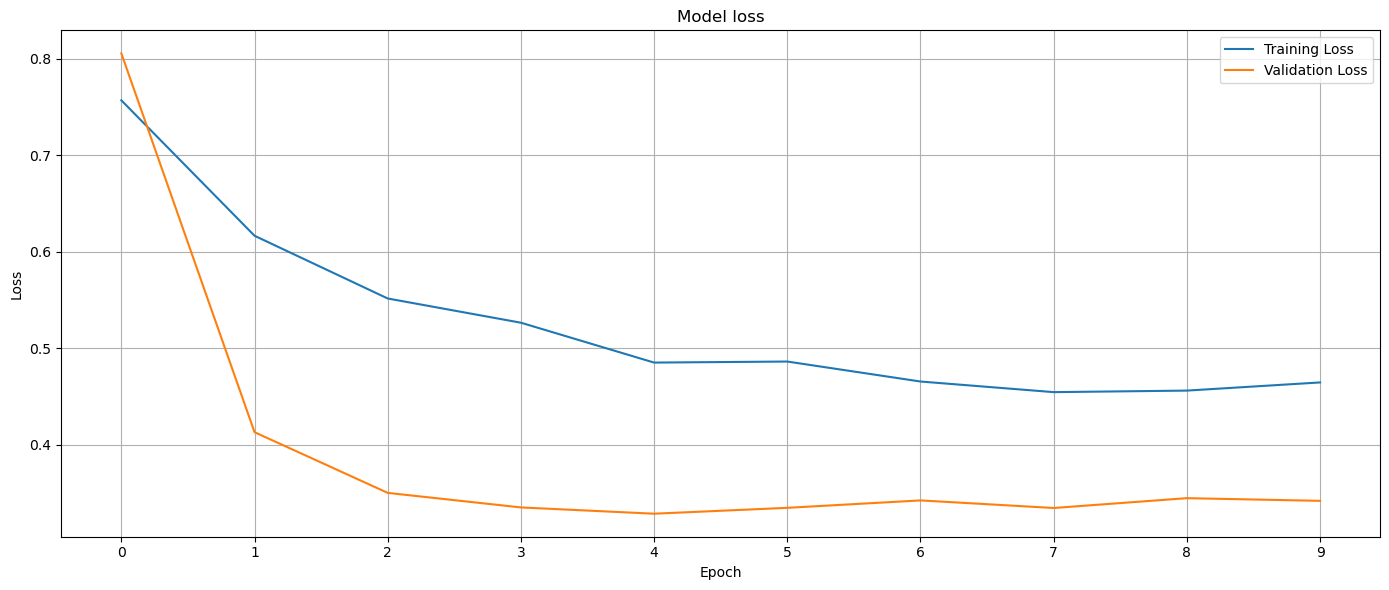

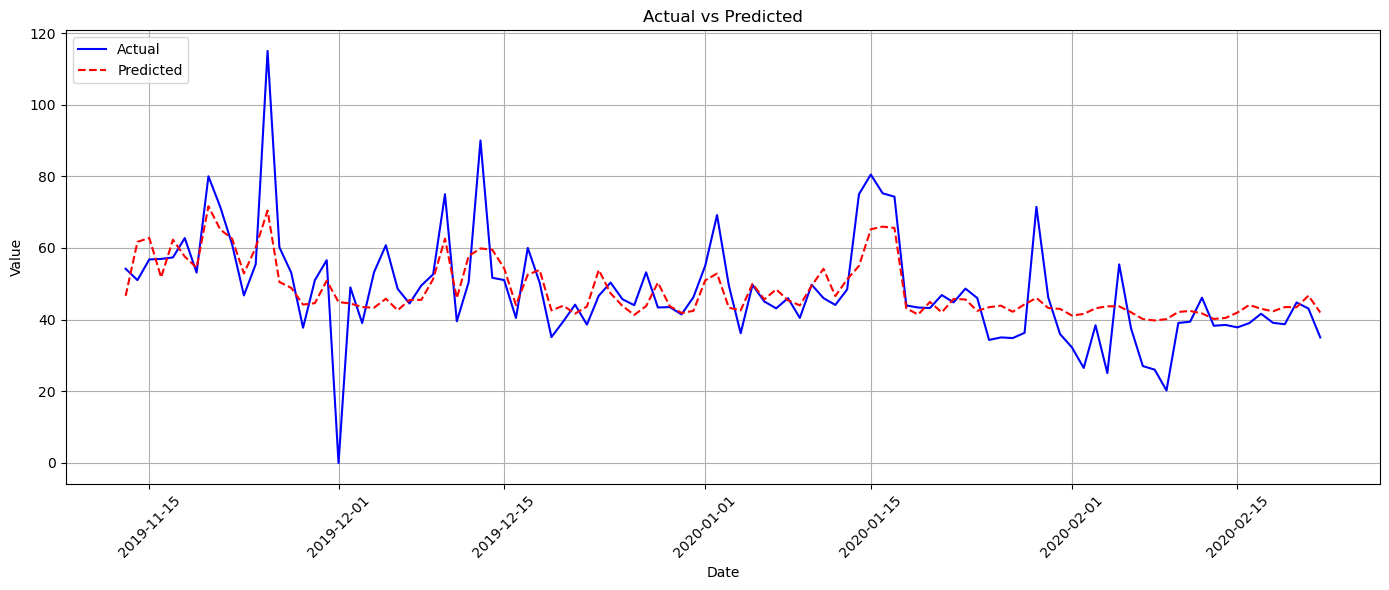

In [4]:
# Plotting the loss during training
plt.figure(figsize=(14, 6))
epochs = range(len(history.history['loss']))
plt.xticks(epochs)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generating date range for the test dataset
date_range = pd.date_range(start=test_dates[0], end=test_dates[-1])

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(date_range, inv_y, label='Actual', color='blue')
plt.plot(date_range, inv_yhat, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted')
plt.ylabel('Value')
plt.xlabel('Date')
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



In [5]:
#Improved LSTM model, better model

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('reshaped_dataset_corrected-2018-2020.csv')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure data is sorted
df = df.sort_values(by='Date')

# Drop data beyond '2020-02-15'
df = df[df['Date'] <= '2020-02-15']

# Generate additional features
df['Rolling_Mean_Price'] = df['Day-ahead Price [EUR/MWh]'].rolling(window=7).mean()
df['Rolling_Mean_Wind'] = df['Wind Offshore  [MW] Day Ahead'].rolling(window=7).mean()

# Save dates before introducing lag features
dates = df['Date'].tolist()

# Drop the 'Date' column after saving
df.drop(columns='Date', inplace=True)

# Generate lag features
for i in range(1, 8):
    df[f'Price_Lag_{i}'] = df['Day-ahead Price [EUR/MWh]'].shift(i)
    df[f'Wind_Lag_{i}'] = df['Wind Offshore  [MW] Day Ahead'].shift(i)

# Drop NaN rows introduced by the lag features
df.dropna(inplace=True)

# Splitting the dataset
n_train_hours = int(len(df) * 0.8)
train, test = df.iloc[:n_train_hours, :], df.iloc[n_train_hours:, :]

# Extracting the last three months of the training data for plotting
train_last_3_months_dates = dates[n_train_hours-90:n_train_hours]  # Dates for the last 3 months of training data
train_last_3_months = train.iloc[-90:]

# Extract test dates
test_dates = dates[n_train_hours:n_train_hours + len(test)]

# Sorting the index
train.sort_index(inplace=True)
test.sort_index(inplace=True)

# Separate target variable
train_X, train_y = train.drop(columns=['Day-ahead Price [EUR/MWh]']), train['Day-ahead Price [EUR/MWh]']
test_X, test_y = test.drop(columns=['Day-ahead Price [EUR/MWh]']), test['Day-ahead Price [EUR/MWh]']

# Scaling the dataset
scaler_X = StandardScaler().fit(train_X)
train_X_scaled = scaler_X.transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

scaler_y = StandardScaler().fit(train_y.values.reshape(-1, 1))
train_y_scaled = scaler_y.transform(train_y.values.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1))

# Reshape for LSTM
train_X_reshaped = train_X_scaled.reshape((train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_reshaped = test_X_scaled.reshape((test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))

# Enhanced LSTM model architecture
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2])))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Optimizer settings with a reduced learning rate
optimizer = Adam(learning_rate=0.003)
model.compile(loss='mae', optimizer=optimizer)

# Using ReduceLROnPlateau to adjust learning rate
lr_adjust = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, verbose=1, min_delta=1e-4)

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_X_reshaped, train_y_scaled, epochs=100, batch_size=16, 
                    validation_data=(test_X_reshaped, test_y_scaled), verbose=2, 
                    shuffle=False, callbacks=[early_stop, lr_adjust])

# Prediction
yhat_scaled = model.predict(test_X_reshaped)

# Inverse scaling
inv_yhat = scaler_y.inverse_transform(yhat_scaled)
inv_y = scaler_y.inverse_transform(test_y_scaled)

# RMSE calculation
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:', rmse)



C:\Users\ridva\AppData\Local\Temp\ipykernel_14244\1647373650.py:17: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\ridva\AppData\Local\Temp\ipykernel_14244\1647373650.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_index(inplace=True)
C:\Users\ridva\AppData\Local\Temp\ipykernel_14244\1647373650.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_index(inplace=True)


Epoch 1/100
24/24 - 7s - loss: 0.7144 - val_loss: 0.4452 - lr: 0.0030 - 7s/epoch - 294ms/step
Epoch 2/100
24/24 - 0s - loss: 0.5875 - val_loss: 0.4490 - lr: 0.0030 - 96ms/epoch - 4ms/step
Epoch 3/100
24/24 - 0s - loss: 0.5522 - val_loss: 0.4047 - lr: 0.0030 - 93ms/epoch - 4ms/step
Epoch 4/100
24/24 - 0s - loss: 0.4961 - val_loss: 0.3754 - lr: 0.0030 - 91ms/epoch - 4ms/step
Epoch 5/100
24/24 - 0s - loss: 0.4654 - val_loss: 0.3689 - lr: 0.0030 - 108ms/epoch - 4ms/step
Epoch 6/100
24/24 - 0s - loss: 0.4429 - val_loss: 0.3479 - lr: 0.0030 - 102ms/epoch - 4ms/step
Epoch 7/100
24/24 - 0s - loss: 0.4019 - val_loss: 0.3194 - lr: 0.0030 - 100ms/epoch - 4ms/step
Epoch 8/100
24/24 - 0s - loss: 0.3794 - val_loss: 0.2872 - lr: 0.0030 - 101ms/epoch - 4ms/step
Epoch 9/100
24/24 - 0s - loss: 0.3692 - val_loss: 0.4029 - lr: 0.0030 - 98ms/epoch - 4ms/step
Epoch 10/100
24/24 - 0s - loss: 0.3773 - val_loss: 0.3185 - lr: 0.0030 - 98ms/epoch - 4ms/step
Epoch 11/100
24/24 - 0s - loss: 0.3625 - val_loss: 0.34

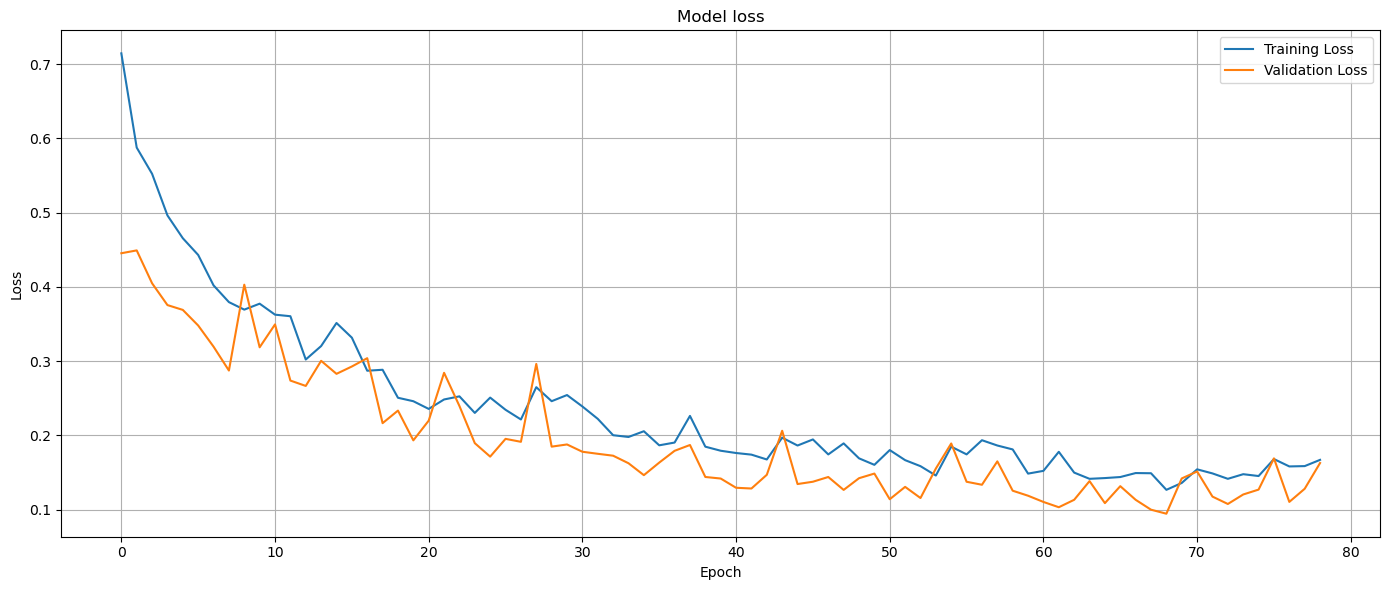

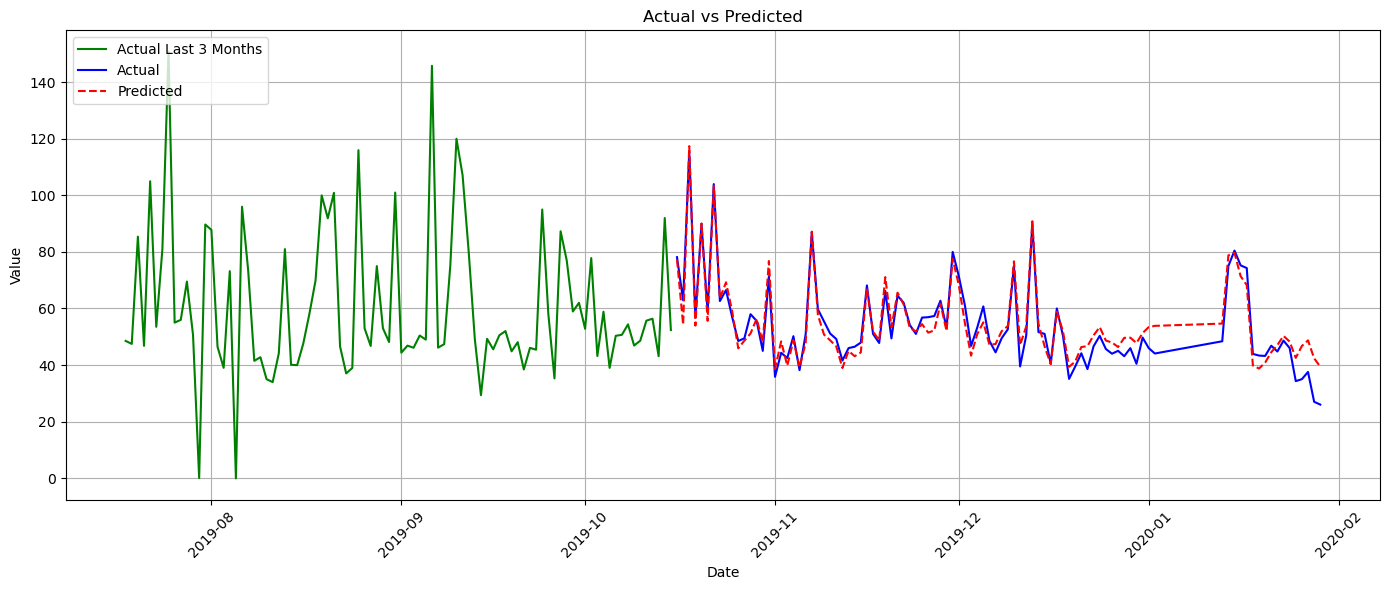

 
Test RMSE: 4.530188170747523


In [6]:
# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot actual vs predicted values, highlighting the last three months before 2019-11-15
combined_dates = train_last_3_months_dates + test_dates
combined_actuals = np.concatenate([train_last_3_months['Day-ahead Price [EUR/MWh]'].values, inv_y.flatten()])

plt.figure(figsize=(14, 6))
plt.plot(combined_dates[:len(train_last_3_months_dates)], train_last_3_months['Day-ahead Price [EUR/MWh]'].values, label='Actual Last 3 Months', color='green')
plt.plot(combined_dates[len(train_last_3_months_dates):], inv_y.flatten(), label='Actual', color='blue')
plt.plot(combined_dates[len(train_last_3_months_dates):], inv_yhat.flatten(), label='Predicted', linestyle='dashed', color='red')
plt.title('Actual vs Predicted')
plt.ylabel('Value')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print(" ")

# RMSE calculation
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:', rmse)